# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/data/Deep_learning

import os
print("Now in:", os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/data/Deep_learning
Now in: /content/drive/MyDrive/ColabNotebooks/data/Deep_learning


Download data with kagglehub

In [3]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [4]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [ ]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


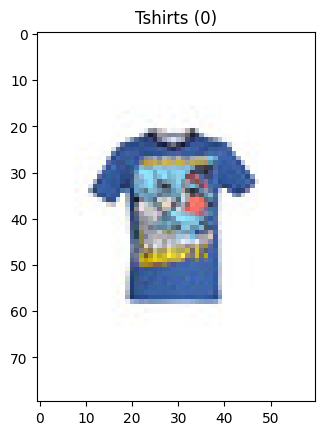

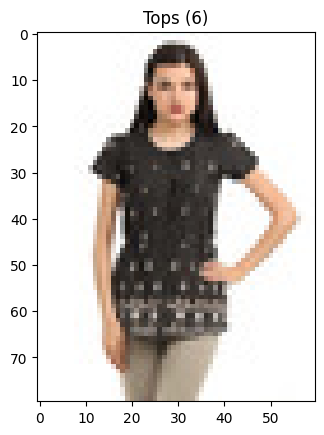

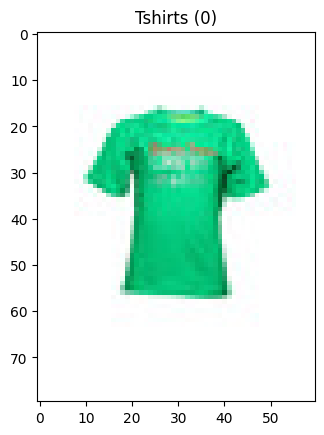

In [23]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [18]:
transform = transforms.Compose([
    transforms.Resize((80, 80)), #resize to 80x80, because the original images have different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [6]:
#IMPORT ALL THE REQUIRED LIBRARIES

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, balanced_accuracy_score


### Model Architecture

In [22]:
class CNN(nn.Module):
    def __init__(self, num_classes, bw = 32, lr= 0.001):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = 0.3),
            nn.Linear(bw*4, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




### Helper Functions

In [ ]:
#import with data loaders
def get_data(train_ds, valid_ds, batch_size=64):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_dl, valid_dl

def loss_batch(model, loss_func, xb, yb, opt=None):

    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)


    return loss.item(), corrects, len(xb), preds, yb


def fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    for epoch in tqdm(range(epochs)):


        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:

            # move data to GPU if available
            xb = xb.to(device)
            yb = yb.to(device)

            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums, *_ = loss_batch(model, loss_func, xb, yb,opt)

            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num


        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0

            all_preds, all_trues = [], []

            for xb, yb in valid_dl:

                xb = xb.to(device)
                yb = yb.to(device)


                # forward
                losses, corrects, nums, preds, yb = loss_batch(model, loss_func, xb, yb)

                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

                all_preds.append(preds.cpu())
                all_trues.append(yb.cpu())



            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            bacc = balanced_accuracy_score(torch.cat(all_trues), torch.cat(all_preds))

            scheduler.step(val_loss) # decrease the learning rate if validation loss increases


        # print the results
        print(
            f'EPOCH with LR {scheduler.get_last_lr()[0]}: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ', f"VAL-BACC: {bacc:.4f} ",end='\n')

        if val_acc >= 0.8 and bacc >= 0.8:
          print("Early Stopping")
          break


### Training the model

In [ ]:
epochs=100 
lr = 0.01

model = CNN(num_classes=39)
# OPTIONAL: load pretrained weights from an earlier run
model.load_state_dict(torch.load('models/fashion_model_weights.pth'))

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5) # decrease the learning rate if validation loss increases
loss_func = F.cross_entropy

train_dl, valid_dl = get_data(train_dataset, main_test_dataset, batch_size=526) # you have to decrease batch size for lower RAM gpus/cpus


fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl)

Using device: cuda


  1%|          | 1/100 [00:22<37:11, 22.54s/it]

EPOCH with LR 0.01: 001/100 LOSS: 0.4121 ACC: 0.8630  VAL-LOSS: 0.4043 VAL-ACC: 0.8678  VAL-BACC: 0.7810 


  2%|▏         | 2/100 [00:45<37:04, 22.70s/it]

EPOCH with LR 0.01: 002/100 LOSS: 0.3970 ACC: 0.8658  VAL-LOSS: 0.4106 VAL-ACC: 0.8703  VAL-BACC: 0.7836 


  3%|▎         | 3/100 [01:07<36:32, 22.60s/it]

EPOCH with LR 0.01: 003/100 LOSS: 0.3876 ACC: 0.8702  VAL-LOSS: 0.4103 VAL-ACC: 0.8663  VAL-BACC: 0.7722 


  4%|▍         | 4/100 [01:30<36:04, 22.55s/it]

EPOCH with LR 0.01: 004/100 LOSS: 0.3838 ACC: 0.8726  VAL-LOSS: 0.3844 VAL-ACC: 0.8768  VAL-BACC: 0.7926 


  5%|▌         | 5/100 [01:52<35:43, 22.57s/it]

EPOCH with LR 0.01: 005/100 LOSS: 0.3798 ACC: 0.8743  VAL-LOSS: 0.3943 VAL-ACC: 0.8763  VAL-BACC: 0.7961 


  6%|▌         | 6/100 [02:15<35:22, 22.58s/it]

EPOCH with LR 0.01: 006/100 LOSS: 0.3751 ACC: 0.8744  VAL-LOSS: 0.3986 VAL-ACC: 0.8718  VAL-BACC: 0.7802 


  7%|▋         | 7/100 [02:38<34:59, 22.57s/it]

EPOCH with LR 0.01: 007/100 LOSS: 0.3733 ACC: 0.8753  VAL-LOSS: 0.3873 VAL-ACC: 0.8783  VAL-BACC: 0.7999 


  8%|▊         | 8/100 [03:00<34:34, 22.55s/it]

EPOCH with LR 0.01: 008/100 LOSS: 0.3695 ACC: 0.8775  VAL-LOSS: 0.4030 VAL-ACC: 0.8698  VAL-BACC: 0.7844 


  9%|▉         | 9/100 [03:23<34:12, 22.55s/it]

EPOCH with LR 0.01: 009/100 LOSS: 0.3679 ACC: 0.8774  VAL-LOSS: 0.3943 VAL-ACC: 0.8743  VAL-BACC: 0.7990 


 10%|█         | 10/100 [03:45<33:49, 22.55s/it]

EPOCH with LR 0.01: 010/100 LOSS: 0.3653 ACC: 0.8759  VAL-LOSS: 0.3841 VAL-ACC: 0.8768  VAL-BACC: 0.7992 


 11%|█         | 11/100 [04:08<33:25, 22.54s/it]

EPOCH with LR 0.01: 011/100 LOSS: 0.3606 ACC: 0.8801  VAL-LOSS: 0.3923 VAL-ACC: 0.8718  VAL-BACC: 0.7854 


 12%|█▏        | 12/100 [04:30<33:03, 22.54s/it]

EPOCH with LR 0.01: 012/100 LOSS: 0.3601 ACC: 0.8806  VAL-LOSS: 0.3957 VAL-ACC: 0.8663  VAL-BACC: 0.7827 


 13%|█▎        | 13/100 [04:53<32:41, 22.55s/it]

EPOCH with LR 0.01: 013/100 LOSS: 0.3591 ACC: 0.8807  VAL-LOSS: 0.4045 VAL-ACC: 0.8703  VAL-BACC: 0.7833 


 13%|█▎        | 13/100 [05:15<35:13, 24.29s/it]

EPOCH with LR 0.01: 014/100 LOSS: 0.3570 ACC: 0.8802  VAL-LOSS: 0.3772 VAL-ACC: 0.8803  VAL-BACC: 0.8044 
Early Stopping


### Saving the model

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'models/fashion_model_weights.pth')

## Task 2

In [ ]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

## Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

## Task 4

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset